# SatelliteImage Test

In [ ]:
"""This module provides a SatelliteImage class for interfacing with satellite images
that are stored in multiple shards on disk"""
import os
import pathlib
from typing import List, Tuple

import dask.array as da
import numba
import numpy as np
import xarray as xr

# Type alias
XarrayDataArray = xr.core.dataarray.DataArray
DaskArray = da.core.Array


class SatelliteImage:
    """Class to combine a satellite image stored in several shards on disk."""

    def __init__(  # pylint: disable=dangerous-default-value
        self,
        shard_paths: List[os.PathLike],
        chunks: dict = {"band": 1, "x": 256, "y": 256},
    ):
        """
        Class to combine a satellite image stored in several shards on disk.
        `SatelliteImage` loads handles to the individual shards of a satellite
        image at the specified `shard_paths` and combines them into a Dask Array that
        can be lazily queried and loaded.
        IMPORTANT: Currently assumes that shards are named according to the format
            `path/to/file/custom_shard_name-XXXXXX-YYYYYYY.tif`
        where
            custom_shard_name is a valid path name without dashes `-`
            XXXXXX is a number such as e.g. 000003493 that gives the x-offset of the
                shards top left corner within the overall bounding box of the image
            YYYYYY is a number such as e.g. 000053025 that gives the y-offset of the
                shards top left corner within the overall bounding box of the image
        Args:
            shard_paths (List[os.PathLike]): Paths to the satellite image shards
            chunks (dict, optional): Chard specification to load for dask and xarray.
                Defaults to {"band": 1, "x": 256, "y": 256}.
        """

        if isinstance(shard_paths, os.PathLike):
            self._load_single_shard(shard_paths, chunks)
        else:
            self._load_multiple_shards(shard_paths, chunks)

    def _load_single_shard(self, path: os.PathLike, chunks: dict) -> None:
        """Load single shard"""
        self.shard_paths: List[os.PathLike] = [pathlib.Path(path)]
        self.shard_offsets: List[Tuple[float]] = [(0, 0)]
        self.shard_handles: List[XarrayDataArray] = [
            xr.open_rasterio(path, chunks=chunks)
        ]
        self.crs: str = self.shard_handles[0].crs
        self.transform: Tuple[float] = self.shard_handles[0].transform

        # Combine shards for one composite image
        self._combined_image = self.shard_handles[0]
        self._combined_x = self.combined_image.x
        self._combined_y = self.combined_image.y

    def _load_multiple_shards(
        self, shard_paths: List[os.PathLike], chunks: dict
    ) -> None:
        """Load multiple shards"""
        self.shard_paths: List[os.PathLike] = [
            pathlib.Path(path) for path in sorted(shard_paths)
        ]
        self.shard_offsets: List[Tuple[float]] = [
            SatelliteImage._get_shard_offset_from_path(path)
            for path in self.shard_paths
        ]
        self.shard_handles: List[XarrayDataArray] = [
            xr.open_rasterio(path, chunks=chunks) for path in self.shard_paths
        ]
        self.crs: str = self.shard_handles[0].crs
        self.transform: Tuple[float] = self.shard_handles[0].transform

        # Combine shards for one composite image
        self._combine_shards()

    @staticmethod
    def _get_shard_offset_from_path(shard_path: os.PathLike) -> Tuple[int, int]:
        x, y = shard_path.stem.split("-")[1:]
        x = "".join(char for char in x if char.isdigit())
        y = "".join(char for char in x if char.isdigit())
        return int(x), int(y)

    @staticmethod
    @numba.njit
    def is_sorted(arr: np.array, reverse: bool = False) -> bool:
        """Return true iff array is sorted ascending (reverse: descending)"""
        sign = -1 if reverse else 1
        for i in range(arr.size - 1):
            if sign * arr[i + 1] < sign * arr[i]:
                return False
        return True

    def _combine_shards(self) -> None:
        """
        Combine all shards of an image into a dask array that can be evaluated lazily.
        """

        block_width = len([elem for elem in self.shard_offsets if elem[0] == 0])
        block_height = len([elem for elem in self.shard_offsets if elem[1] == 0])

        assert block_width * block_height == len(self.shard_paths)

        # Note: This is a slightly awkward creation of the block matrix like e.g.
        #   [[handle[0], handle[1], handle[2] ],
        #    [handle[3], handle[4], handle[5] ]]
        # because numpy reshaping of `shard_handles` list caused problems with dask
        block_arrangement = [
            [self.shard_handles[row * block_width + col] for col in range(block_width)]
            for row in range(block_height)
        ]

        first_row = block_arrangement[0]
        first_col = [row[0] for row in block_arrangement]

        self._combined_x = xr.concat([handle.x for handle in first_row], "x")
        assert SatelliteImage.is_sorted(self._combined_x.data)  # sanity check

        self._combined_y = xr.concat([handle.y for handle in first_col], "y")
        assert SatelliteImage.is_sorted(
            self._combined_y.data, reverse=True
        )  # sanity check

        self._combined_image: DaskArray = da.block(block_arrangement)

    @property
    def x(self) -> XarrayDataArray:
        return self._combined_x

    @property
    def y(self) -> XarrayDataArray:
        return self._combined_y

    @property
    def combined_image(self) -> DaskArray:
        return self._combined_image

    @property
    def shape(self) -> Tuple[int, int, int]:
        return self.combined_image.shape

    @property
    def bounds(self) -> Tuple[float, float, float, float]:
        xmin = self.x.data.min()
        ymin = self.y.data.min()
        xmax = self.x.data.max()
        ymax = self.y.data.max()
        return xmin, ymin, xmax, ymax

    def xy_to_index(self):
        raise NotImplementedError

    def x_to_col(self, x_val: float, side="left") -> int:
        return np.searchsorted(self.x, x_val, side=side)

    def y_to_row(self, y_val: float, side="left") -> int:
        return np.searchsorted(-self.y, -y_val, side=side)

    def __getitem__(self, multi_index) -> DaskArray:
        return self.combined_image[multi_index]

In [2]:
GWS_DATA_DIR = pathlib.Path(
    "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity"
)
SENTINEL_DIR = GWS_DATA_DIR / "sentinel2_data"
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

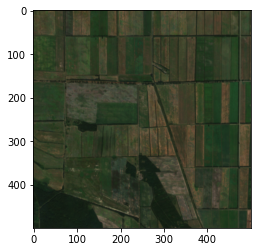

In [15]:
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image


example_folder = SENTINEL_DIR / "Example"
image_paths = list(example_folder.glob("*[0-9].tif"))

img = SatelliteImage(image_paths)

# sample tile
rgb_bands = [2, 1, 0]
sample_tile = reshape_as_image(img[rgb_bands, 0:500, 0:500] / 3000)
sample_tile.compute()

plt.imshow(sample_tile)